In [1]:
import pandas as pd
import numpy as np
import scanpy as sc #pip install scanpy
import anndata
import scipy

import sys,os
import scvi

Global seed set to 0


In [2]:
import matplotlib
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.multitest import multipletests

sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.9.6 anndata==0.9.2 umap==0.5.4 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.2 pynndescent==0.5.10


In [3]:
adata = sc.read_h5ad('/home/jupyter/tmpmount/vasculature/nuclei/nuclei_datasets/whole_nuclei_objects/vasc_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 67421 × 14675
    obs: 'subject', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'age_death', 'msex', 'pmi', 'ADdiag2types', 'percent.mt', 'percent.rp', 'celltype', 'cellsubtype', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'kit', 'study', 'organ', 'cell_or_nuclei', 'ID', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'lung_cell_states', 'cell_state', 'lung_region', 'sample', 'sex', 'suspension_type', 'SampleID', 'PatientID', 'snRNAPreparation', 'RNA_snn_res.0.5', 'seurat_clusters', 'oricluster', 'newcluster', 'Dataset', 'development_stage', 'pancreas_cell_states', 'cell_type', 'skeletal_muscle_cell_states', 'suspension_uuid', 'liver_cell_states', 'liver_region', 'age_group', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'heart_cell_states', 'heart_region', 'Cell', 'Treat', 'Sample', 'Region', 'nCount_SC

/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


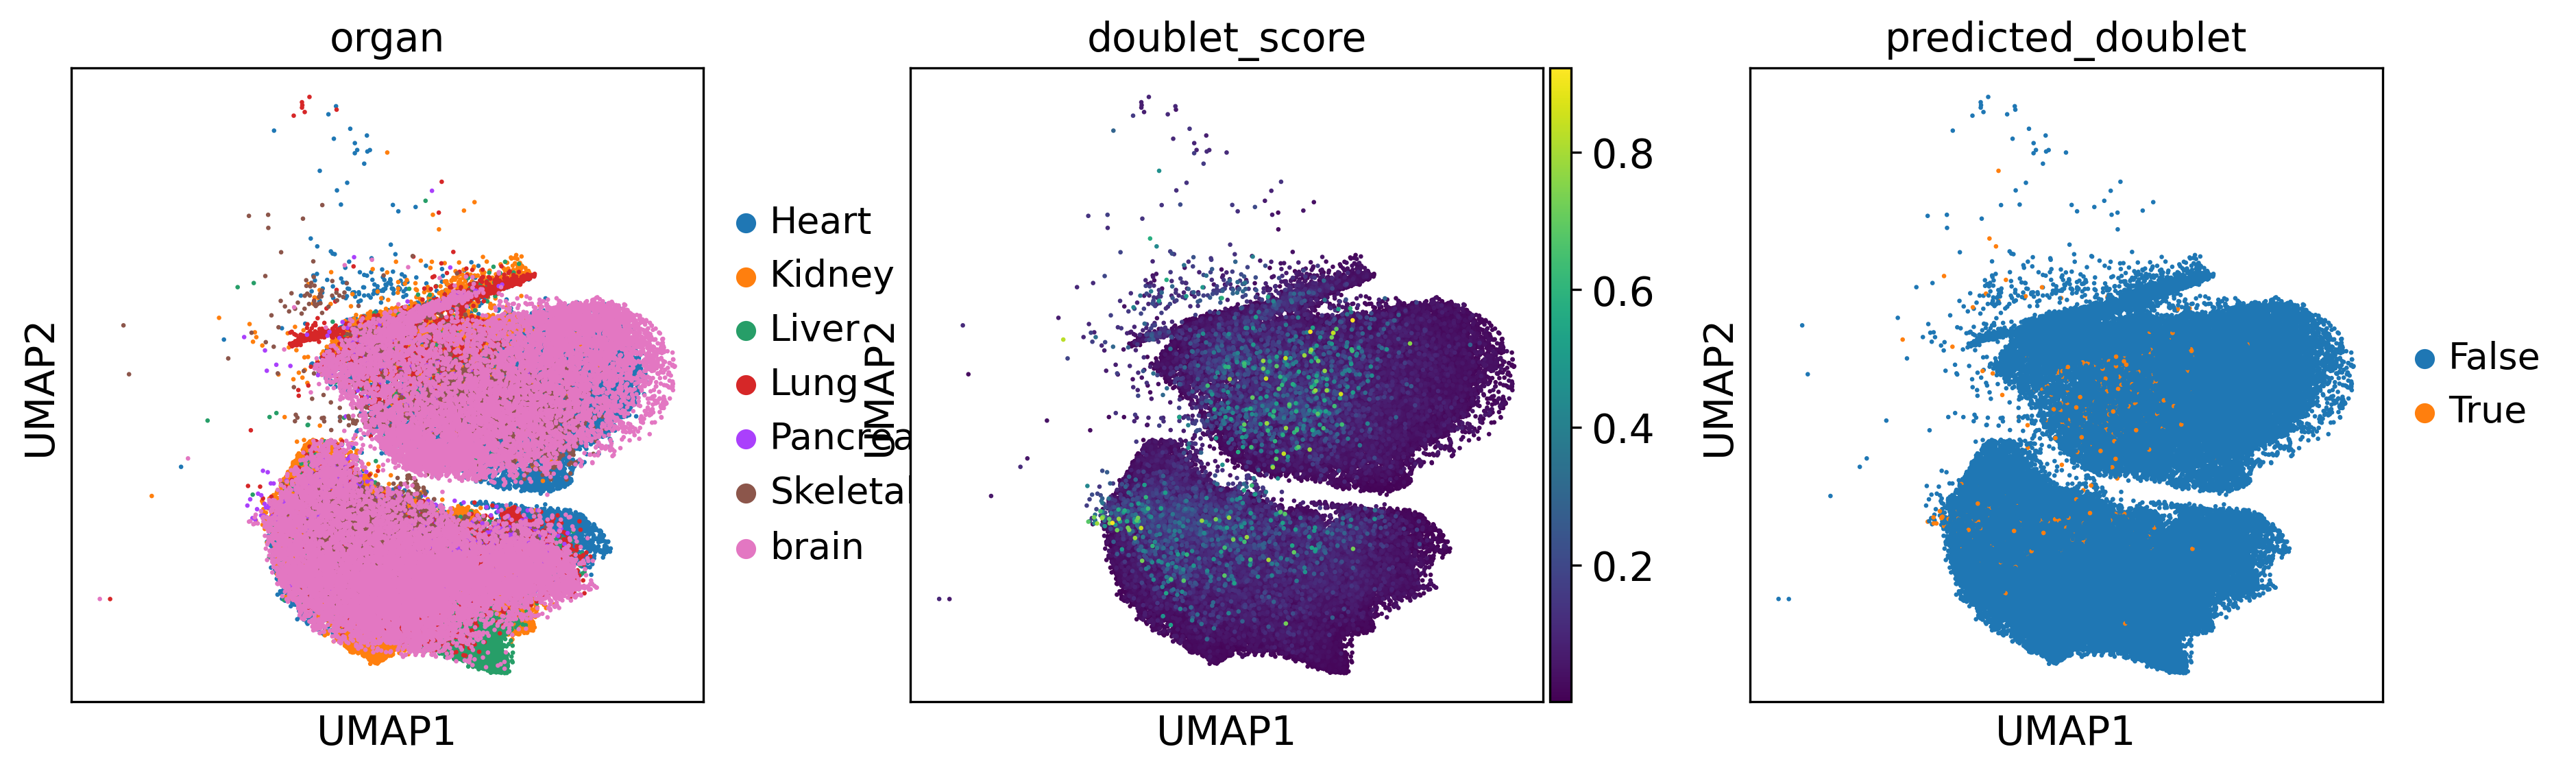

In [4]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata, color = ['organ', 'doublet_score', 'predicted_doublet'], ncols = 3, size = 10)

In [5]:
adata.obs.doublet_score <= 0.4

CCTTACGTCTACTATC-1-HCAHeart7664653    True
AGGCCGTCAGCGATCC-1-HCAHeart7829979    True
CGACAGCAGTTGTCGT-1-H0037_LV           True
ACGCCGAGTCCATCCT-1-HCAHeart7888928    True
AACCCAAAGGACAGCT-1-H0025_RV           True
                                      ... 
31719                                 True
Hippocampus.CTACAGAGTGGTATGG-38-1     True
5652                                  True
32494                                 True
D20-125069.4207                       True
Name: doublet_score, Length: 67421, dtype: bool

In [6]:
adata = adata[adata.obs.doublet_score <= 0.4]
adata

View of AnnData object with n_obs × n_vars = 67130 × 14675
    obs: 'subject', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'age_death', 'msex', 'pmi', 'ADdiag2types', 'percent.mt', 'percent.rp', 'celltype', 'cellsubtype', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'kit', 'study', 'organ', 'cell_or_nuclei', 'ID', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'lung_cell_states', 'cell_state', 'lung_region', 'sample', 'sex', 'suspension_type', 'SampleID', 'PatientID', 'snRNAPreparation', 'RNA_snn_res.0.5', 'seurat_clusters', 'oricluster', 'newcluster', 'Dataset', 'development_stage', 'pancreas_cell_states', 'cell_type', 'skeletal_muscle_cell_states', 'suspension_uuid', 'liver_cell_states', 'liver_region', 'age_group', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'heart_cell_states', 'heart_region', 'Cell', 'Treat', 'Sample', 'Region', 'n

In [10]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=5000,
    layer="counts",
    subset = True)
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="donor", 
    categorical_covariate_keys=['kit'], # study is out as this is confounded by organs
    continuous_covariate_keys=['total_counts', 'n_genes_by_counts','pct_counts_mt', 'pct_counts_rb'] #,'score_stress_genes''score_stress_genes' 'pct_counts_mt', 'pct_counts_rb','score_stress_genes'
)
vae = scvi.model.SCVI(adata, n_layers = 2, n_latent=30) #, n_latent=30
#scvi.data.view_anndata_setup(adata)
vae
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
adata.X.shape
sc.pp.neighbors(adata, use_rep="X_scVI")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/opt/conda/envs/scvi/lib/python3.8/site-packages/scvi/data/_utils.py:168: UserWarning: Category 96 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=119 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 119/119: 100%|██████████| 119/119 [12:21<00:00,  6.23s/it, loss=997, v_num=1]   
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)


In [11]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


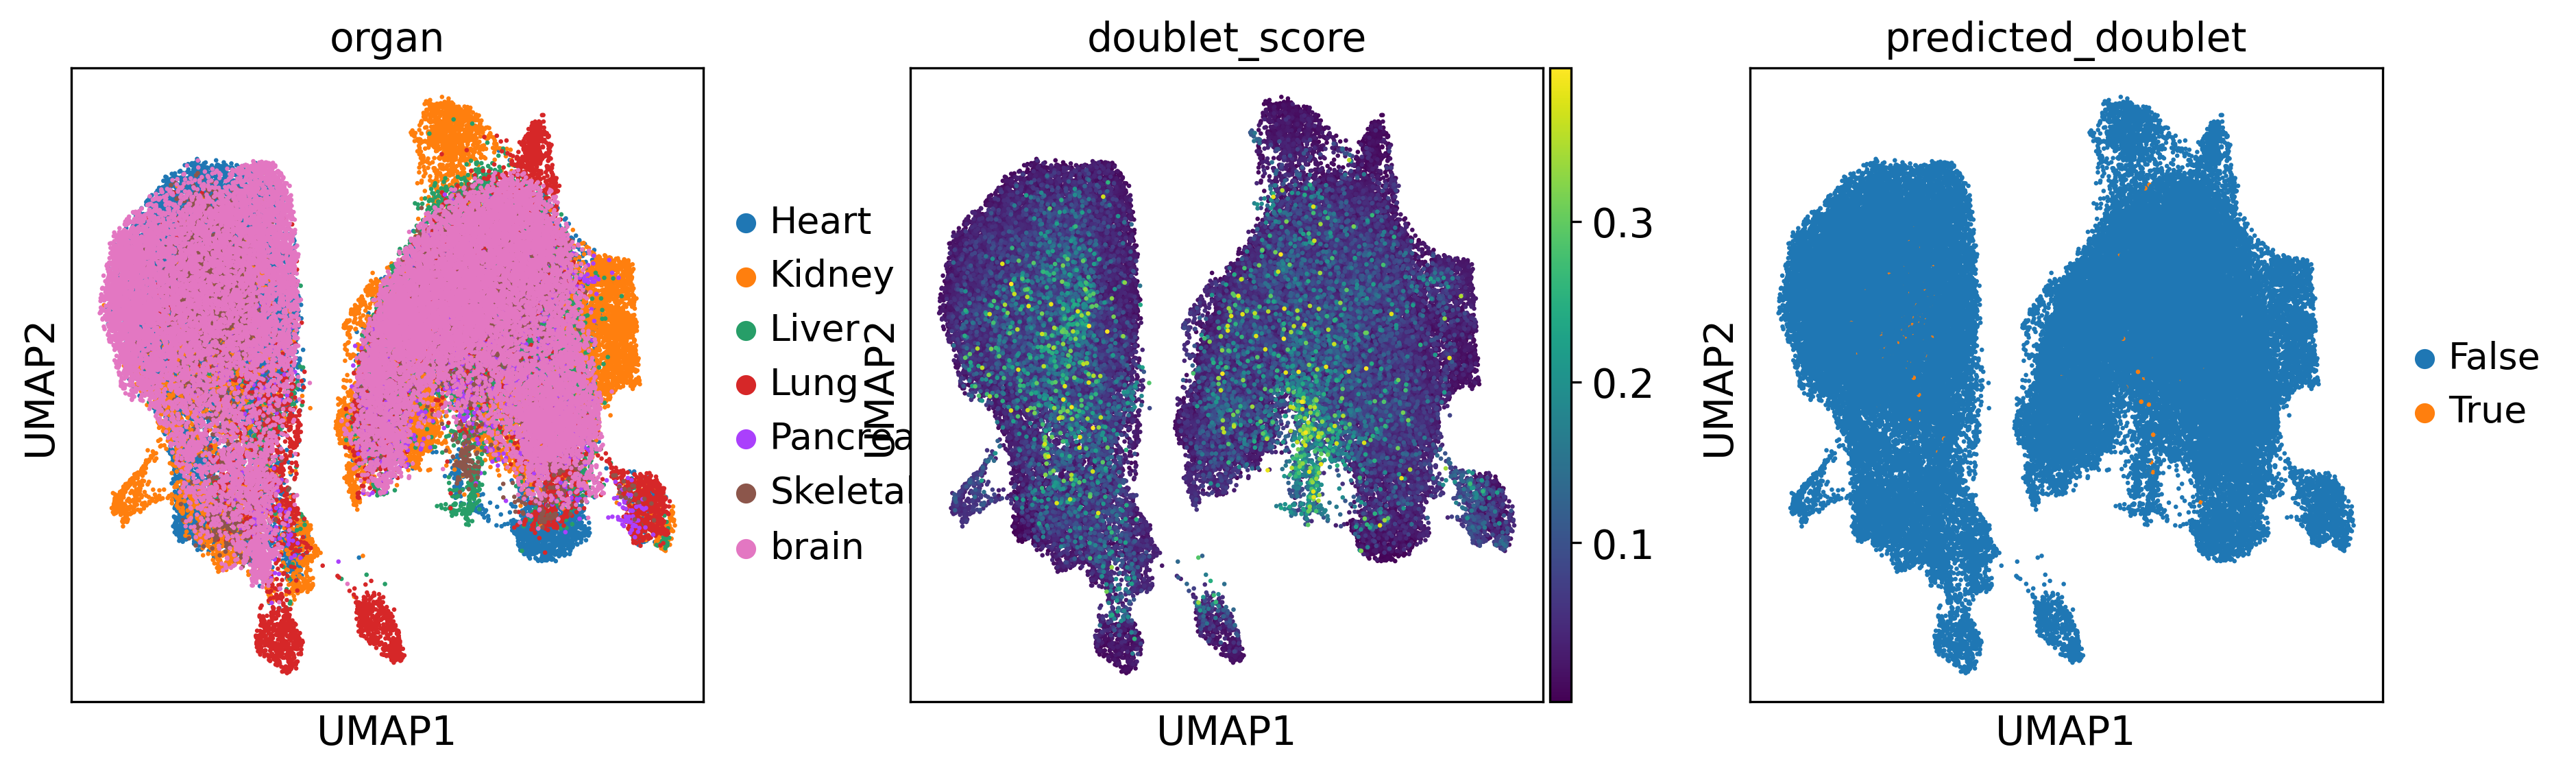

In [12]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata, color = ['organ', 'doublet_score', 'predicted_doublet'], ncols = 3, size = 10)

In [13]:
sc.tl.leiden(adata, resolution = 0.5, key_added = 'leiden_0.5')

running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:28)


/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


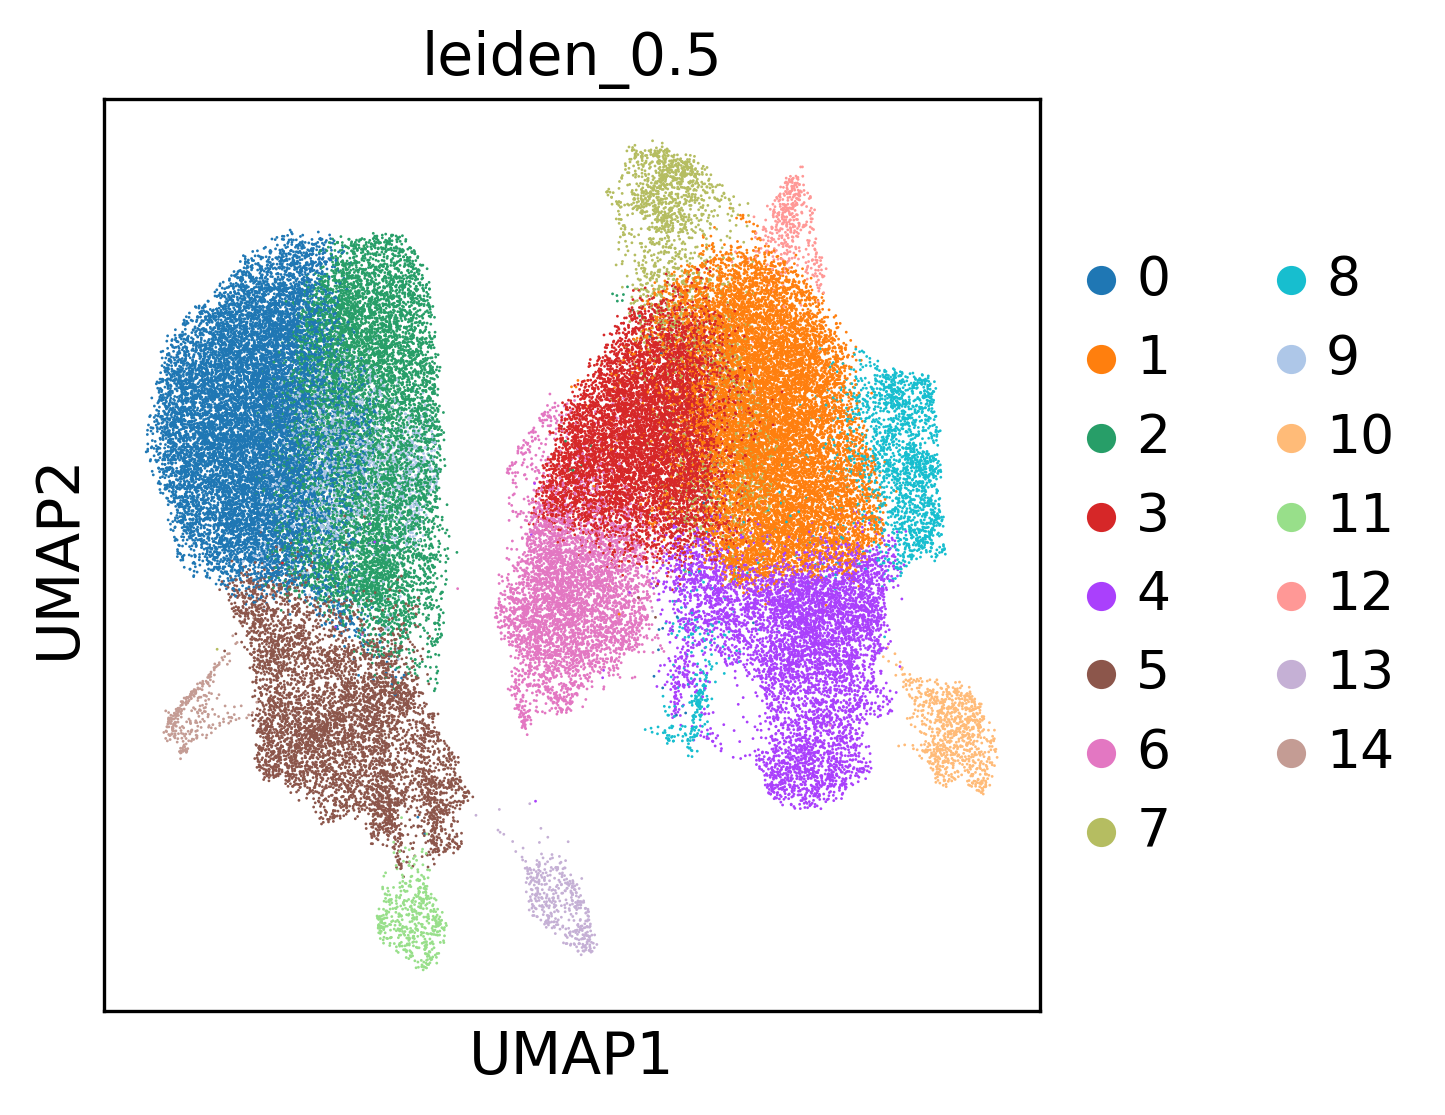

In [14]:
sc.pl.umap(adata, color = ['leiden_0.5']) 

In [15]:
sc.tl.leiden(adata, resolution = 0.1, key_added = 'leiden_0.1')

running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:06)


/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


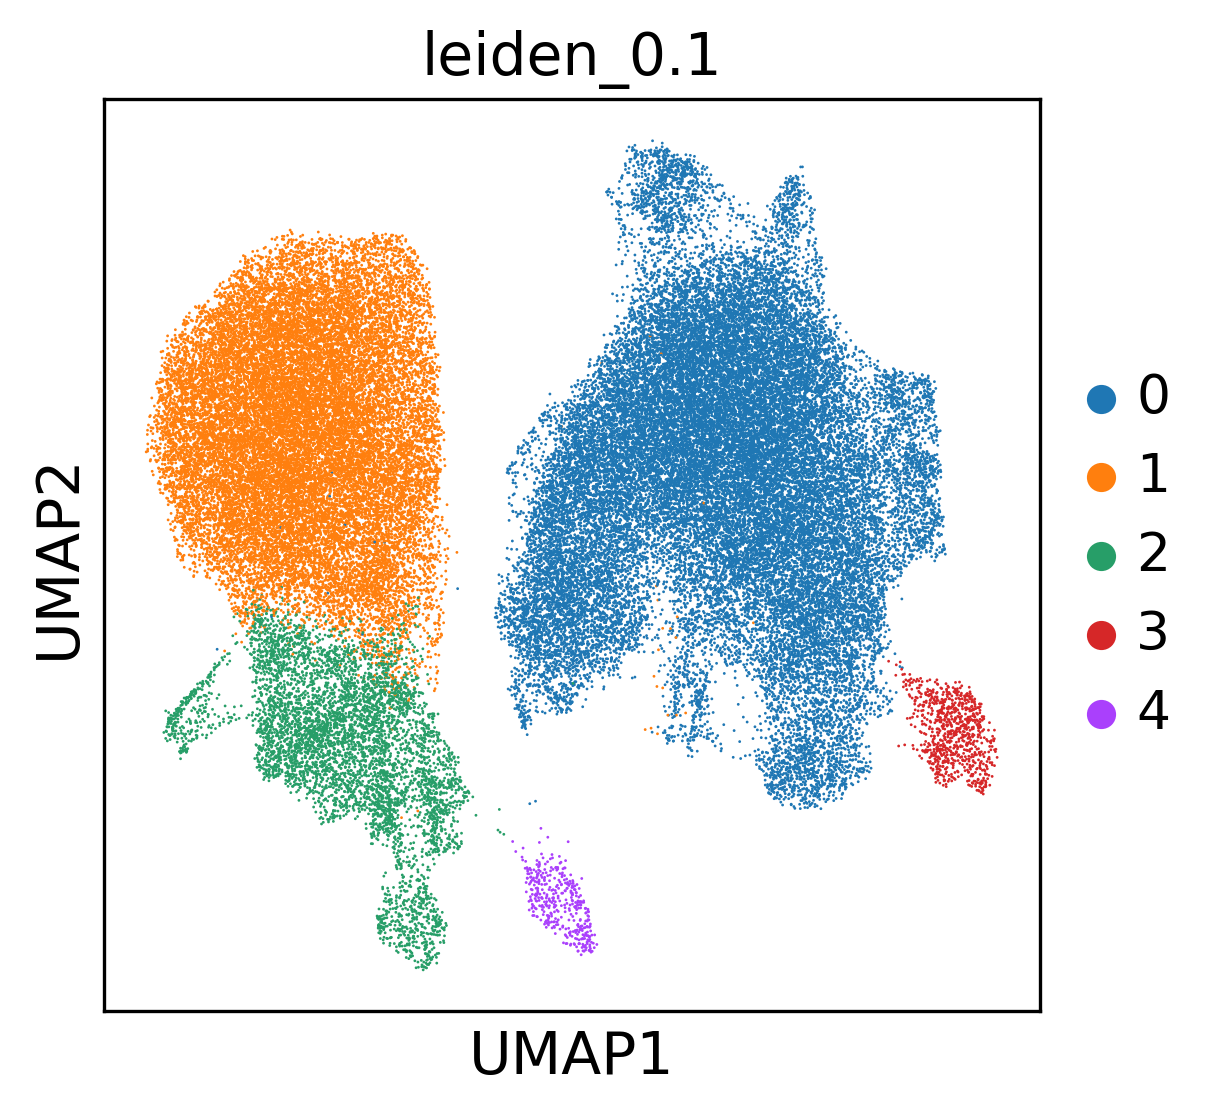

In [16]:
sc.pl.umap(adata, color = ['leiden_0.1']) 

In [23]:
adata

AnnData object with n_obs × n_vars = 67130 × 5000
    obs: 'subject', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'age_death', 'msex', 'pmi', 'ADdiag2types', 'percent.mt', 'percent.rp', 'celltype', 'cellsubtype', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'kit', 'study', 'organ', 'cell_or_nuclei', 'ID', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'lung_cell_states', 'cell_state', 'lung_region', 'sample', 'sex', 'suspension_type', 'SampleID', 'PatientID', 'snRNAPreparation', 'RNA_snn_res.0.5', 'seurat_clusters', 'oricluster', 'newcluster', 'Dataset', 'development_stage', 'pancreas_cell_states', 'cell_type', 'skeletal_muscle_cell_states', 'suspension_uuid', 'liver_cell_states', 'liver_region', 'age_group', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'heart_cell_states', 'heart_region', 'Cell', 'Treat', 'Sample', 'Region', 'nCount_SCT

# write out to the object with all genes

In [24]:
bdata = sc.read_h5ad('/home/jupyter/tmpmount/vasculature/nuclei/nuclei_datasets/whole_nuclei_objects/vasc_subset.h5ad')
bdata

AnnData object with n_obs × n_vars = 67421 × 14675
    obs: 'subject', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'age_death', 'msex', 'pmi', 'ADdiag2types', 'percent.mt', 'percent.rp', 'celltype', 'cellsubtype', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'kit', 'study', 'organ', 'cell_or_nuclei', 'ID', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'lung_cell_states', 'cell_state', 'lung_region', 'sample', 'sex', 'suspension_type', 'SampleID', 'PatientID', 'snRNAPreparation', 'RNA_snn_res.0.5', 'seurat_clusters', 'oricluster', 'newcluster', 'Dataset', 'development_stage', 'pancreas_cell_states', 'cell_type', 'skeletal_muscle_cell_states', 'suspension_uuid', 'liver_cell_states', 'liver_region', 'age_group', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'heart_cell_states', 'heart_region', 'Cell', 'Treat', 'Sample', 'Region', 'nCount_SC

In [25]:
bdata = bdata[bdata.obs.doublet_score <= 0.4]
bdata

View of AnnData object with n_obs × n_vars = 67130 × 14675
    obs: 'subject', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'age_death', 'msex', 'pmi', 'ADdiag2types', 'percent.mt', 'percent.rp', 'celltype', 'cellsubtype', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'kit', 'study', 'organ', 'cell_or_nuclei', 'ID', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'lung_cell_states', 'cell_state', 'lung_region', 'sample', 'sex', 'suspension_type', 'SampleID', 'PatientID', 'snRNAPreparation', 'RNA_snn_res.0.5', 'seurat_clusters', 'oricluster', 'newcluster', 'Dataset', 'development_stage', 'pancreas_cell_states', 'cell_type', 'skeletal_muscle_cell_states', 'suspension_uuid', 'liver_cell_states', 'liver_region', 'age_group', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'heart_cell_states', 'heart_region', 'Cell', 'Treat', 'Sample', 'Region', 'n

In [26]:
sc.pp.highly_variable_genes(
    bdata,
    flavor="seurat_v3",
    n_top_genes=5000,
    layer="counts",
    subset = False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:148: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': 'seurat_v3'}


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [27]:
bdata.obsm = adata.obsm
bdata.obsp = adata.obsp
bdata.obs = adata.obs
bdata.uns = adata.uns

In [28]:
bdata

AnnData object with n_obs × n_vars = 67130 × 14675
    obs: 'subject', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'id', 'library_id', 'batch', 'brain_region', 'age_death', 'msex', 'pmi', 'ADdiag2types', 'percent.mt', 'percent.rp', 'celltype', 'cellsubtype', 'donor', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'kit', 'study', 'organ', 'cell_or_nuclei', 'ID', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'lung_cell_states', 'cell_state', 'lung_region', 'sample', 'sex', 'suspension_type', 'SampleID', 'PatientID', 'snRNAPreparation', 'RNA_snn_res.0.5', 'seurat_clusters', 'oricluster', 'newcluster', 'Dataset', 'development_stage', 'pancreas_cell_states', 'cell_type', 'skeletal_muscle_cell_states', 'suspension_uuid', 'liver_cell_states', 'liver_region', 'age_group', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score', 'heart_cell_states', 'heart_region', 'Cell', 'Treat', 'Sample', 'Region', 'nCount_SC

/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/scvi/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


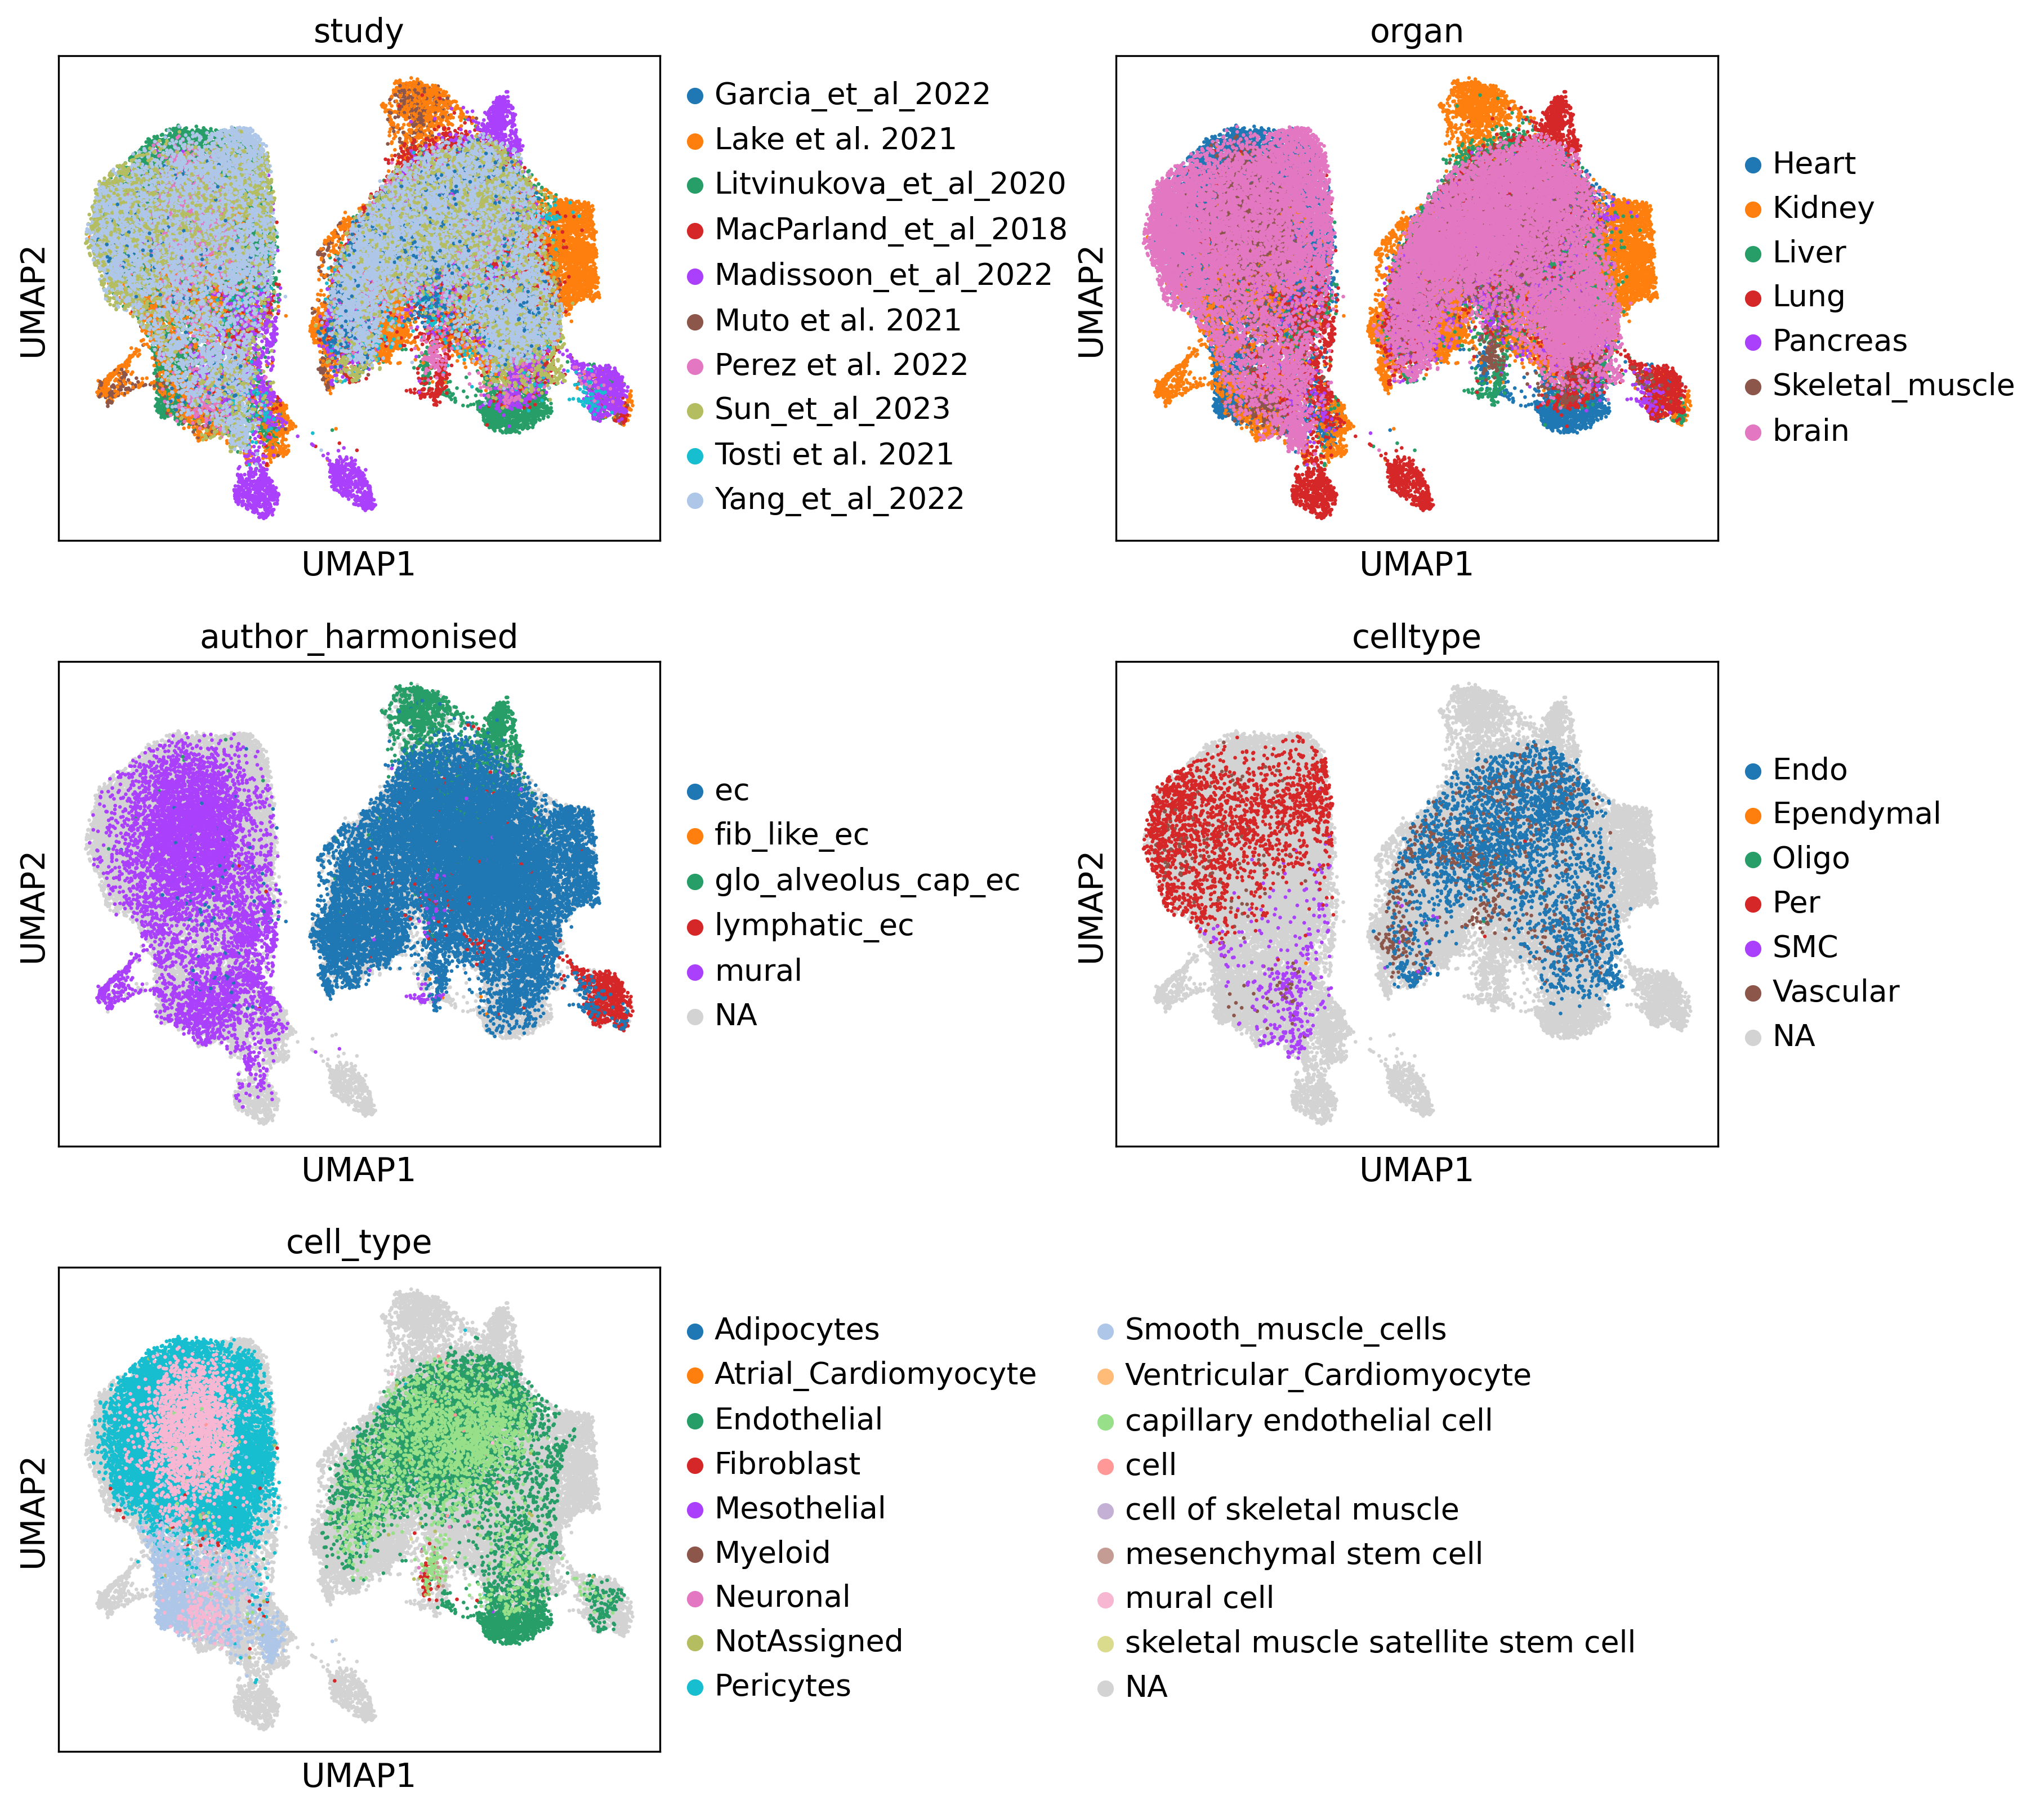

In [29]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(bdata, color = ['study', 'organ', 'author_harmonised', 'celltype', 'cell_type'], wspace = 0.6, ncols = 2, size = 10)

In [30]:
# write the nuclei vasc object with all the doublets is
bdata.write('/home/jupyter/tmpmount/vasculature/nuclei/nuclei_datasets/whole_nuclei_objects/vasc_nuclei_scvi_without_doublets.h5ad', compression = 'gzip')